## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Network Architecture

In [3]:
torch.cuda.is_available()

True

In [4]:
dtype = torch.cuda.FloatTensor

In [5]:
class eelfff(nn.Module):
    
    def __init__(self, grid_size, output, layer_size=2048):
        super(eelfff, self).__init__()
        self.grid_size = grid_size
        self.output = output
        self.layer_size = layer_size
        
        # inputs: image + rot vec + id compare + pos-other_pos
        self.net = nn.Sequential(
                                nn.Linear(self.grid_size**2, self.layer_size),
                                nn.ReLU(inplace=True),
                                nn.Linear(self.layer_size, self.layer_size),
                                nn.ReLU(inplace=True),
                                nn.Linear(self.layer_size, self.output)
                            )

    def forward(self, feat):
        return self.net(feat)

test network with random data

In [6]:
tic = time.clock()
N = 32
grid_size = 10
output = 1

model = eelfff(grid_size, output).type(dtype)
feat = Variable(torch.randn(N,grid_size**2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([32, 1])
340.21s = 5.67m elapsed for this test


In [8]:
fire_neigh = [(-1,0),(1,0),(0,-1),(0,1)]

## Heuristic

In [9]:
def heuristic(sim, size_control):
    action = []
    grid_size = sim.grid_size
    center = (grid_size+1)//2
    cc = x_to_col(center)
    center_idx = np.asscalar(np.ravel_multi_index(np.array([[cc],[cc]]),(grid_size,grid_size),order='F'))
    fires = sim.fires
    scores = {}
    for s in range(5):
        scores[s] = []
        
    for (x,y) in fires:
        rf = y_to_row(grid_size,y)
        cf = x_to_col(x)
        
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = rf + dr
            cn = cf + dc
            if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                counter += 1
                
        e = np.ravel_multi_index(np.array([[rf],[cf]]),(grid_size,grid_size),order='F')
        scores[counter].append(np.asscalar(e))
        
    using_set = 4
    while(len(action) < size_control):
        if using_set >= 0:
            if not scores[using_set]:
                using_set += -1
                continue

            for e in scores[using_set]:
                action.append(e)

                if len(action) >= size_control:
                    break
                    
            using_set += -1
    
        else:
            action.append(center_idx)
            
    return action
    

## Benchmark greedy solution

In [118]:
results = []

In [119]:
grid_size = 10
num_control = 5
dp = 0.15/0.2763

seeds = range(1000)

In [120]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        action = heuristic(sim, num_control)
        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
                            
    if (i+1) % 100 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 100 simulations
finished 200 simulations
finished 300 simulations
finished 400 simulations
finished 500 simulations
finished 600 simulations
finished 700 simulations
finished 800 simulations
finished 900 simulations
finished 1000 simulations
5.27s = 0.09m elapsed


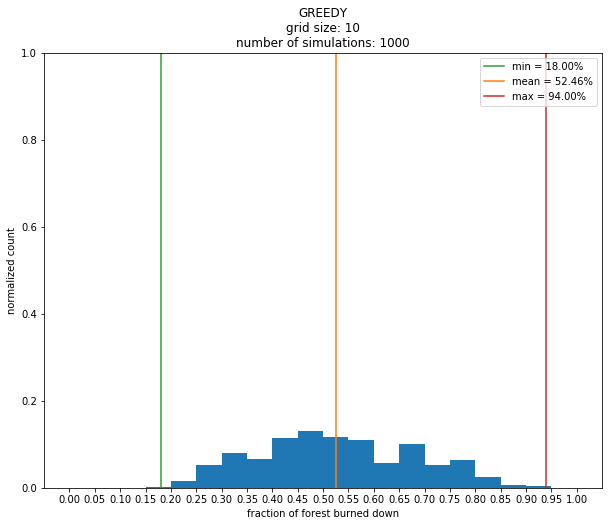

In [121]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('GREEDY\ngrid size: %d\nnumber of simulations: %d' %(grid_size,len(results)))
plt.legend(loc=1)

# plt.savefig('greedy.png', bbox_inches='tight')

## Reward function

In [143]:
def eelfff_reward(state, action, size_control):
    reward = []
    
    ctrl = []
    grid_size = state.shape[0]
    r,c = np.unravel_index(action, (grid_size,grid_size), order='F')
    for (rp,cp) in zip(r,c):
        x = col_to_x(cp)
        y = row_to_y(grid_size,rp)

        if (x,y) not in ctrl and state[rp,cp] in [1]:
            counter = 0
            for (dr,dc) in fire_neigh:
                rn = rp + dr
                cn = cp + dc
                if rn>=0 and rn<grid_size and cn>=0 and cn<grid_size and sim.state[rn,cn] in [0]:
                    counter += 1
                
            reward.append(counter / len(fire_neigh))
            
        else:
            reward.append(0)
            
        ctrl.append((x,y))

    #reward /= size_control
            
    return reward, ctrl

## Train the network

In [156]:
# simulator parameters
grid_size = 10
output = grid_size**2
num_control = 5
dp = 0.15/0.2763

# replay memory
memory_size = 10000 #5000
min_exp_size = 100 #100
sars = None

state_st = grid_size**2
action_st = state_st
action_ed = action_st + num_control
reward_st = action_ed
reward_ed = reward_st + num_control
next_state_st = reward_ed
exp_size = (grid_size**2)*2 + num_control + num_control

# network instances
layer_size = 2048
model = eelfff(grid_size, output, layer_size).type(dtype)
target = eelfff(grid_size, output, layer_size).type(dtype)
update_max = 200 #200
update_ctr = 1

# optimizer
gamma = 0.95
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# exploration
eps_init = 1
eps_finl = 0.15
anneal_range = 2000 #2000
eps = eps_init
episode_ctr = 0

# loss function
loss_fn = nn.MSELoss(size_average=True)

# plotting data structures
rew_hist = []
loss_hist = []

pf1 = False
pf2 = False

In [166]:
seeds = range(1000,5000)

In [167]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end and sim.iter < 30:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        action = None
        if np.random.rand() <= eps:
            #action = np.random.randint(0, high=grid_size**2, size=num_control)
            action = heuristic(sim, num_control)

        else:
            state_var = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argpartition(Q, -num_control)[-num_control:]
            
        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
        
        # generate next state and save experience
        next_state = sim.state.reshape((grid_size**2, ))
        
        if sars is None:
            sars = np.zeros((1, exp_size))
        else:
            sars = np.vstack((sars, np.zeros((1, exp_size))))    
        
        sars[-1,0:state_st]  = state
        sars[-1,action_st:action_ed] = action
        sars[-1,reward_st:reward_ed] = reward
        sars[-1,next_state_st:] = next_state
        seed_rew += np.sum(reward)
        
        # skip network update if not enough experiences
        if sars is None or sars.shape[0] < min_exp_size or sars.shape[0] < batch_size:
            continue
        elif not pf1:
            pf1 = True
            print('---DEBUG: generated enough experiences')
                        
        # create a batch of experiences from memory and update network
        loss = 0
        
        batch = sars[np.random.choice(sars.shape[0], batch_size, replace=False), :]
        batch_states = Variable(torch.from_numpy(batch[:,0:state_st])).type(dtype)
        batch_actions = Variable(torch.from_numpy(batch[:,action_st:action_ed])).type(torch.cuda.LongTensor)
        x = model(batch_states).gather(1, batch_actions)
        
        batch_rewards = batch[:,reward_st:reward_ed]
        batch_next_states = Variable(torch.from_numpy(batch[:,next_state_st:])).type(dtype)
        tt = target(batch_next_states).data.cpu().numpy()
        tt = batch_rewards + gamma*np.sort(tt, axis=1)[:,-num_control:]
        tt = Variable(torch.from_numpy(tt), requires_grad=False).type(dtype)
        loss += loss_fn(x, tt)

        loss_hist.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
            
        # anneal exploration rate
        if eps > eps_finl:
            eps += -(eps_init - eps_finl)/anneal_range
        elif not pf2:
            pf2 = True
            print('---DEBUG: finished annealing the exploration rate')
        
        # update target network periodically
        if update_ctr % update_max == 0:
            target = copy.deepcopy(model)
            print('---DEBUG: updated target network (%d)' %(update_ctr / update_max))
        update_ctr += 1
        
        # drop from memory if too many elements
        if sars.shape[0] > memory_size:
            sars = sars[sars.shape[0]-memory_size:,:]   
                    
    frac_burn = sim.stats[2]/np.sum(sim.stats)
    print('seed %03d: %03d steps, %0.2f reward, %0.4f burnt' %(s, sim.iter, seed_rew, frac_burn))
    rew_hist.append(seed_rew)
    episode_ctr += 1
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

seed 1000: 030 steps, 16.50 reward, 0.9000 burnt
seed 1001: 030 steps, 14.75 reward, 0.8600 burnt
seed 1002: 030 steps, 17.00 reward, 0.9300 burnt
seed 1003: 030 steps, 15.25 reward, 0.8700 burnt
---DEBUG: updated target network (158)
seed 1004: 030 steps, 17.75 reward, 0.6900 burnt
seed 1005: 030 steps, 12.00 reward, 0.5500 burnt
seed 1006: 030 steps, 18.25 reward, 0.7900 burnt
seed 1007: 030 steps, 14.00 reward, 0.8200 burnt
seed 1008: 030 steps, 13.25 reward, 0.9000 burnt
seed 1009: 030 steps, 18.50 reward, 0.7400 burnt
seed 1010: 030 steps, 18.00 reward, 0.8800 burnt
---DEBUG: updated target network (159)
seed 1011: 030 steps, 13.25 reward, 0.6700 burnt
seed 1012: 008 steps, 8.75 reward, 0.2300 burnt
seed 1013: 030 steps, 13.50 reward, 0.8600 burnt
seed 1014: 030 steps, 15.25 reward, 0.6000 burnt
seed 1015: 030 steps, 15.50 reward, 0.7400 burnt
seed 1016: 030 steps, 12.50 reward, 0.7100 burnt
seed 1017: 030 steps, 17.25 reward, 0.7200 burnt
---DEBUG: updated target network (160)
se

seed 1151: 030 steps, 24.25 reward, 0.8600 burnt
---DEBUG: updated target network (179)
seed 1152: 030 steps, 14.50 reward, 0.8000 burnt
seed 1153: 030 steps, 11.75 reward, 0.9000 burnt
seed 1154: 030 steps, 14.00 reward, 0.8700 burnt
seed 1155: 030 steps, 18.75 reward, 0.8400 burnt
seed 1156: 027 steps, 13.25 reward, 0.7900 burnt
seed 1157: 030 steps, 20.75 reward, 0.8700 burnt
seed 1158: 030 steps, 15.75 reward, 0.7600 burnt
---DEBUG: updated target network (180)
seed 1159: 030 steps, 17.25 reward, 0.7800 burnt
seed 1160: 030 steps, 24.50 reward, 0.8600 burnt
seed 1161: 030 steps, 15.50 reward, 0.9300 burnt
seed 1162: 030 steps, 19.75 reward, 0.8800 burnt
seed 1163: 030 steps, 11.75 reward, 0.9500 burnt
seed 1164: 030 steps, 17.50 reward, 0.9000 burnt
seed 1165: 030 steps, 15.75 reward, 0.6800 burnt
---DEBUG: updated target network (181)
seed 1166: 030 steps, 13.50 reward, 0.8500 burnt
seed 1167: 030 steps, 16.50 reward, 0.8300 burnt
seed 1168: 030 steps, 15.50 reward, 0.8500 burnt
s

seed 1302: 030 steps, 14.00 reward, 0.9100 burnt
seed 1303: 030 steps, 17.50 reward, 0.7500 burnt
seed 1304: 030 steps, 14.25 reward, 0.9200 burnt
---DEBUG: updated target network (201)
seed 1305: 030 steps, 16.25 reward, 0.8600 burnt
seed 1306: 030 steps, 15.25 reward, 0.7400 burnt
seed 1307: 030 steps, 17.25 reward, 0.8100 burnt
seed 1308: 030 steps, 14.25 reward, 0.9400 burnt
seed 1309: 029 steps, 13.75 reward, 0.5900 burnt
seed 1310: 030 steps, 12.50 reward, 0.8800 burnt
seed 1311: 030 steps, 15.00 reward, 0.8400 burnt
---DEBUG: updated target network (202)
seed 1312: 030 steps, 12.75 reward, 0.7900 burnt
seed 1313: 030 steps, 16.75 reward, 0.6900 burnt
seed 1314: 030 steps, 17.25 reward, 0.7600 burnt
seed 1315: 030 steps, 21.75 reward, 0.8600 burnt
seed 1316: 030 steps, 21.50 reward, 0.8200 burnt
seed 1317: 030 steps, 15.00 reward, 0.8400 burnt
seed 1318: 030 steps, 18.25 reward, 0.8000 burnt
---DEBUG: updated target network (203)
seed 1319: 030 steps, 13.00 reward, 0.7400 burnt
s

seed 1453: 029 steps, 13.25 reward, 0.5700 burnt
seed 1454: 030 steps, 21.75 reward, 0.8300 burnt
seed 1455: 030 steps, 14.00 reward, 0.8100 burnt
seed 1456: 030 steps, 15.00 reward, 0.8800 burnt
seed 1457: 030 steps, 21.00 reward, 0.9300 burnt
seed 1458: 030 steps, 16.75 reward, 0.8500 burnt
---DEBUG: updated target network (223)
seed 1459: 030 steps, 15.00 reward, 0.6200 burnt
seed 1460: 030 steps, 17.00 reward, 0.7100 burnt
seed 1461: 030 steps, 17.75 reward, 0.8800 burnt
seed 1462: 029 steps, 14.00 reward, 0.8200 burnt
seed 1463: 029 steps, 17.25 reward, 0.9700 burnt
seed 1464: 030 steps, 15.50 reward, 0.7500 burnt
seed 1465: 030 steps, 17.25 reward, 0.8000 burnt
---DEBUG: updated target network (224)
seed 1466: 030 steps, 20.25 reward, 0.8000 burnt
seed 1467: 029 steps, 17.25 reward, 0.4800 burnt
seed 1468: 030 steps, 17.25 reward, 0.9000 burnt
seed 1469: 030 steps, 11.25 reward, 0.9100 burnt
seed 1470: 030 steps, 17.25 reward, 0.8700 burnt
seed 1471: 030 steps, 15.00 reward, 0.91

seed 1605: 030 steps, 19.00 reward, 0.8400 burnt
---DEBUG: updated target network (244)
seed 1606: 030 steps, 18.50 reward, 0.8500 burnt
seed 1607: 029 steps, 15.75 reward, 0.7300 burnt
seed 1608: 030 steps, 19.50 reward, 0.6100 burnt
seed 1609: 030 steps, 17.00 reward, 0.9000 burnt
seed 1610: 030 steps, 15.25 reward, 0.9600 burnt
seed 1611: 030 steps, 16.50 reward, 0.9600 burnt
seed 1612: 030 steps, 17.50 reward, 0.8600 burnt
---DEBUG: updated target network (245)
seed 1613: 030 steps, 16.25 reward, 0.8100 burnt
seed 1614: 030 steps, 17.75 reward, 0.9500 burnt
seed 1615: 030 steps, 14.25 reward, 0.9700 burnt
seed 1616: 030 steps, 15.75 reward, 0.7600 burnt
seed 1617: 030 steps, 18.25 reward, 0.8300 burnt
seed 1618: 030 steps, 17.00 reward, 0.9700 burnt
seed 1619: 030 steps, 16.25 reward, 0.6200 burnt
---DEBUG: updated target network (246)
seed 1620: 030 steps, 20.50 reward, 0.8600 burnt
seed 1621: 030 steps, 15.00 reward, 0.9000 burnt
seed 1622: 030 steps, 19.00 reward, 0.7200 burnt
s

seed 1755: 030 steps, 14.50 reward, 0.8400 burnt
seed 1756: 030 steps, 14.50 reward, 0.8500 burnt
seed 1757: 026 steps, 19.25 reward, 0.7700 burnt
seed 1758: 030 steps, 18.25 reward, 0.9100 burnt
---DEBUG: updated target network (266)
seed 1759: 030 steps, 16.50 reward, 0.6500 burnt
seed 1760: 030 steps, 19.75 reward, 0.6900 burnt
seed 1761: 024 steps, 17.25 reward, 0.8500 burnt
seed 1762: 028 steps, 11.50 reward, 0.9000 burnt
seed 1763: 030 steps, 16.75 reward, 0.8400 burnt
seed 1764: 030 steps, 16.25 reward, 0.8000 burnt
seed 1765: 030 steps, 22.25 reward, 0.8600 burnt
seed 1766: 030 steps, 17.00 reward, 0.7400 burnt
---DEBUG: updated target network (267)
seed 1767: 030 steps, 17.00 reward, 0.9100 burnt
seed 1768: 030 steps, 17.50 reward, 0.9200 burnt
seed 1769: 030 steps, 18.75 reward, 0.8300 burnt
seed 1770: 030 steps, 18.50 reward, 0.8500 burnt
seed 1771: 030 steps, 20.75 reward, 0.7500 burnt
seed 1772: 014 steps, 11.25 reward, 0.2900 burnt
seed 1773: 030 steps, 16.50 reward, 0.85

---DEBUG: updated target network (287)
seed 1907: 030 steps, 18.00 reward, 0.8400 burnt
seed 1908: 030 steps, 17.50 reward, 0.8200 burnt
seed 1909: 030 steps, 22.00 reward, 0.8800 burnt
seed 1910: 023 steps, 13.50 reward, 0.6000 burnt
seed 1911: 030 steps, 14.75 reward, 0.7000 burnt
seed 1912: 030 steps, 18.75 reward, 0.6200 burnt
seed 1913: 030 steps, 19.75 reward, 0.8500 burnt
seed 1914: 030 steps, 14.50 reward, 0.8800 burnt
---DEBUG: updated target network (288)
seed 1915: 030 steps, 16.00 reward, 0.7200 burnt
seed 1916: 030 steps, 12.25 reward, 0.9500 burnt
seed 1917: 030 steps, 15.75 reward, 0.8700 burnt
seed 1918: 030 steps, 19.50 reward, 0.7600 burnt
seed 1919: 030 steps, 12.75 reward, 0.6600 burnt
seed 1920: 030 steps, 18.25 reward, 0.7200 burnt
---DEBUG: updated target network (289)
seed 1921: 030 steps, 17.50 reward, 0.8300 burnt
seed 1922: 030 steps, 13.75 reward, 0.7700 burnt
seed 1923: 030 steps, 15.00 reward, 0.8100 burnt
seed 1924: 030 steps, 16.25 reward, 0.8300 burnt
s

seed 2057: 030 steps, 14.25 reward, 0.6900 burnt
seed 2058: 030 steps, 19.50 reward, 0.8400 burnt
seed 2059: 030 steps, 21.50 reward, 0.9200 burnt
seed 2060: 030 steps, 16.50 reward, 0.8900 burnt
---DEBUG: updated target network (309)
seed 2061: 030 steps, 24.50 reward, 0.7200 burnt
seed 2062: 030 steps, 14.25 reward, 0.9400 burnt
seed 2063: 030 steps, 21.75 reward, 0.7400 burnt
seed 2064: 030 steps, 12.00 reward, 0.8800 burnt
seed 2065: 030 steps, 17.00 reward, 0.6900 burnt
seed 2066: 030 steps, 13.75 reward, 0.9100 burnt
seed 2067: 030 steps, 15.75 reward, 0.4300 burnt
---DEBUG: updated target network (310)
seed 2068: 030 steps, 13.75 reward, 0.8400 burnt
seed 2069: 030 steps, 17.00 reward, 0.8700 burnt
seed 2070: 030 steps, 15.75 reward, 0.8900 burnt
seed 2071: 030 steps, 16.00 reward, 0.6800 burnt
seed 2072: 030 steps, 13.25 reward, 0.9800 burnt
seed 2073: 030 steps, 18.00 reward, 0.8600 burnt
seed 2074: 030 steps, 19.00 reward, 0.9100 burnt
---DEBUG: updated target network (311)
s

seed 2208: 030 steps, 16.25 reward, 0.9200 burnt
---DEBUG: updated target network (330)
seed 2209: 029 steps, 14.50 reward, 0.9400 burnt
seed 2210: 030 steps, 12.25 reward, 0.8200 burnt
seed 2211: 030 steps, 16.75 reward, 0.7800 burnt
seed 2212: 030 steps, 17.75 reward, 0.9200 burnt
seed 2213: 030 steps, 18.50 reward, 0.8700 burnt
seed 2214: 030 steps, 21.00 reward, 0.8400 burnt
seed 2215: 030 steps, 19.50 reward, 0.9100 burnt
---DEBUG: updated target network (331)
seed 2216: 030 steps, 14.25 reward, 0.9200 burnt
seed 2217: 028 steps, 20.25 reward, 0.6900 burnt
seed 2218: 030 steps, 20.50 reward, 0.8700 burnt
seed 2219: 030 steps, 15.00 reward, 0.8400 burnt
seed 2220: 030 steps, 23.00 reward, 0.8600 burnt
seed 2221: 030 steps, 19.75 reward, 0.8300 burnt
seed 2222: 030 steps, 16.50 reward, 0.8800 burnt
---DEBUG: updated target network (332)
seed 2223: 030 steps, 20.00 reward, 0.7500 burnt
seed 2224: 030 steps, 15.25 reward, 0.8900 burnt
seed 2225: 030 steps, 16.00 reward, 0.8300 burnt
s

seed 2359: 030 steps, 18.25 reward, 0.9100 burnt
seed 2360: 030 steps, 18.50 reward, 0.7000 burnt
seed 2361: 030 steps, 17.75 reward, 0.6700 burnt
seed 2362: 030 steps, 19.75 reward, 0.9400 burnt
---DEBUG: updated target network (352)
seed 2363: 030 steps, 16.00 reward, 0.8100 burnt
seed 2364: 030 steps, 16.25 reward, 0.8500 burnt
seed 2365: 030 steps, 13.75 reward, 0.8400 burnt
seed 2366: 030 steps, 20.00 reward, 0.8100 burnt
seed 2367: 030 steps, 15.50 reward, 0.9500 burnt
seed 2368: 020 steps, 11.75 reward, 0.4000 burnt
seed 2369: 030 steps, 13.50 reward, 0.8800 burnt
---DEBUG: updated target network (353)
seed 2370: 030 steps, 18.50 reward, 0.9000 burnt
seed 2371: 030 steps, 14.50 reward, 0.9000 burnt
seed 2372: 030 steps, 12.75 reward, 0.7000 burnt
seed 2373: 030 steps, 14.50 reward, 0.8400 burnt
seed 2374: 030 steps, 18.00 reward, 0.6300 burnt
seed 2375: 030 steps, 18.00 reward, 0.8600 burnt
seed 2376: 030 steps, 16.50 reward, 0.6500 burnt
---DEBUG: updated target network (354)
s

---DEBUG: updated target network (373)
seed 2510: 030 steps, 18.75 reward, 0.8700 burnt
seed 2511: 030 steps, 17.00 reward, 0.7900 burnt
seed 2512: 030 steps, 16.75 reward, 0.7400 burnt
seed 2513: 030 steps, 17.25 reward, 0.7500 burnt
seed 2514: 030 steps, 19.75 reward, 0.8800 burnt
seed 2515: 030 steps, 17.25 reward, 0.8400 burnt
seed 2516: 030 steps, 21.75 reward, 0.7100 burnt
---DEBUG: updated target network (374)
seed 2517: 029 steps, 16.00 reward, 0.8300 burnt
seed 2518: 030 steps, 18.25 reward, 0.8800 burnt
seed 2519: 030 steps, 17.50 reward, 0.9100 burnt
seed 2520: 030 steps, 17.50 reward, 0.9100 burnt
seed 2521: 028 steps, 21.25 reward, 0.7200 burnt
seed 2522: 030 steps, 18.50 reward, 0.5700 burnt
seed 2523: 030 steps, 12.00 reward, 0.9400 burnt
---DEBUG: updated target network (375)
seed 2524: 030 steps, 15.50 reward, 0.9300 burnt
seed 2525: 030 steps, 14.75 reward, 0.8200 burnt
seed 2526: 030 steps, 18.75 reward, 0.7400 burnt
seed 2527: 030 steps, 15.75 reward, 0.9000 burnt
s

seed 2661: 030 steps, 12.00 reward, 0.7600 burnt
seed 2662: 030 steps, 15.25 reward, 0.9000 burnt
---DEBUG: updated target network (395)
seed 2663: 030 steps, 16.25 reward, 0.7500 burnt
seed 2664: 030 steps, 12.50 reward, 0.7400 burnt
seed 2665: 030 steps, 17.25 reward, 0.8800 burnt
seed 2666: 030 steps, 17.50 reward, 0.8700 burnt
seed 2667: 030 steps, 16.75 reward, 0.9500 burnt
seed 2668: 030 steps, 11.25 reward, 0.5000 burnt
seed 2669: 030 steps, 12.75 reward, 0.9000 burnt
---DEBUG: updated target network (396)
seed 2670: 030 steps, 16.75 reward, 0.7600 burnt
seed 2671: 030 steps, 21.75 reward, 0.6900 burnt
seed 2672: 030 steps, 19.50 reward, 0.9900 burnt
seed 2673: 030 steps, 13.50 reward, 0.5900 burnt
seed 2674: 030 steps, 15.50 reward, 0.9200 burnt
seed 2675: 030 steps, 17.50 reward, 0.7800 burnt
seed 2676: 030 steps, 12.75 reward, 0.8900 burnt
---DEBUG: updated target network (397)
seed 2677: 030 steps, 17.00 reward, 0.9500 burnt
seed 2678: 030 steps, 16.00 reward, 0.8000 burnt
s

seed 2811: 030 steps, 19.00 reward, 0.5800 burnt
seed 2812: 030 steps, 14.50 reward, 0.7000 burnt
seed 2813: 030 steps, 17.25 reward, 0.7200 burnt
seed 2814: 030 steps, 14.75 reward, 0.4900 burnt
seed 2815: 023 steps, 14.75 reward, 0.7800 burnt
seed 2816: 025 steps, 17.50 reward, 0.9100 burnt
---DEBUG: updated target network (417)
seed 2817: 030 steps, 17.50 reward, 0.9500 burnt
seed 2818: 030 steps, 13.25 reward, 0.9800 burnt
seed 2819: 030 steps, 16.00 reward, 0.9500 burnt
seed 2820: 030 steps, 13.50 reward, 0.7600 burnt
seed 2821: 027 steps, 17.50 reward, 0.7800 burnt
seed 2822: 030 steps, 15.75 reward, 0.9000 burnt
seed 2823: 030 steps, 16.00 reward, 0.9300 burnt
---DEBUG: updated target network (418)
seed 2824: 030 steps, 12.75 reward, 0.6400 burnt
seed 2825: 030 steps, 20.50 reward, 0.8500 burnt
seed 2826: 030 steps, 18.50 reward, 0.8500 burnt
seed 2827: 030 steps, 18.75 reward, 0.6900 burnt
seed 2828: 030 steps, 17.50 reward, 0.6700 burnt
seed 2829: 030 steps, 19.25 reward, 0.77

seed 2962: 030 steps, 18.75 reward, 0.8000 burnt
seed 2963: 030 steps, 14.00 reward, 0.9100 burnt
---DEBUG: updated target network (438)
seed 2964: 030 steps, 15.25 reward, 0.9000 burnt
seed 2965: 030 steps, 11.50 reward, 0.7500 burnt
seed 2966: 030 steps, 17.75 reward, 0.6200 burnt
seed 2967: 030 steps, 9.50 reward, 0.9300 burnt
seed 2968: 030 steps, 15.00 reward, 0.9000 burnt
seed 2969: 030 steps, 16.75 reward, 0.9200 burnt
---DEBUG: updated target network (439)
seed 2970: 030 steps, 12.25 reward, 0.8400 burnt
seed 2971: 030 steps, 17.25 reward, 0.9200 burnt
seed 2972: 030 steps, 10.00 reward, 0.7400 burnt
seed 2973: 030 steps, 13.75 reward, 0.8700 burnt
seed 2974: 030 steps, 19.50 reward, 0.7700 burnt
seed 2975: 030 steps, 15.50 reward, 0.8300 burnt
seed 2976: 030 steps, 17.75 reward, 0.8900 burnt
---DEBUG: updated target network (440)
seed 2977: 030 steps, 18.50 reward, 0.9100 burnt
seed 2978: 030 steps, 19.75 reward, 0.8500 burnt
seed 2979: 030 steps, 15.50 reward, 0.7600 burnt
se

seed 3113: 030 steps, 12.75 reward, 0.9200 burnt
seed 3114: 030 steps, 15.00 reward, 0.8900 burnt
seed 3115: 030 steps, 14.25 reward, 0.7600 burnt
seed 3116: 030 steps, 14.75 reward, 0.9200 burnt
---DEBUG: updated target network (460)
seed 3117: 026 steps, 16.25 reward, 0.5800 burnt
seed 3118: 030 steps, 18.75 reward, 0.8000 burnt
seed 3119: 030 steps, 14.75 reward, 0.9500 burnt
seed 3120: 030 steps, 14.25 reward, 0.6900 burnt
seed 3121: 030 steps, 16.50 reward, 0.8000 burnt
seed 3122: 030 steps, 19.25 reward, 0.6800 burnt
seed 3123: 030 steps, 21.00 reward, 0.8800 burnt
---DEBUG: updated target network (461)
seed 3124: 030 steps, 11.25 reward, 0.6900 burnt
seed 3125: 030 steps, 15.25 reward, 0.8700 burnt
seed 3126: 030 steps, 19.50 reward, 0.7600 burnt
seed 3127: 030 steps, 9.25 reward, 0.8800 burnt
seed 3128: 030 steps, 20.00 reward, 0.9100 burnt
seed 3129: 029 steps, 16.25 reward, 0.8600 burnt
seed 3130: 030 steps, 14.00 reward, 0.8800 burnt
---DEBUG: updated target network (462)
se

---DEBUG: updated target network (481)
seed 3265: 030 steps, 16.75 reward, 0.8200 burnt
seed 3266: 030 steps, 16.50 reward, 0.7900 burnt
seed 3267: 030 steps, 12.75 reward, 0.8100 burnt
seed 3268: 030 steps, 13.75 reward, 0.7200 burnt
seed 3269: 030 steps, 18.75 reward, 0.8900 burnt
seed 3270: 030 steps, 14.50 reward, 0.5400 burnt
seed 3271: 030 steps, 20.00 reward, 0.7400 burnt
---DEBUG: updated target network (482)
seed 3272: 030 steps, 11.50 reward, 0.6900 burnt
seed 3273: 030 steps, 17.00 reward, 0.8300 burnt
seed 3274: 030 steps, 16.00 reward, 0.9100 burnt
seed 3275: 030 steps, 20.25 reward, 0.9100 burnt
seed 3276: 030 steps, 18.75 reward, 0.9000 burnt
seed 3277: 030 steps, 17.25 reward, 0.7400 burnt
---DEBUG: updated target network (483)
seed 3278: 030 steps, 16.25 reward, 0.8300 burnt
seed 3279: 030 steps, 17.00 reward, 0.9200 burnt
seed 3280: 030 steps, 13.25 reward, 0.8400 burnt
seed 3281: 030 steps, 16.00 reward, 0.9200 burnt
seed 3282: 030 steps, 19.50 reward, 0.6800 burnt
s

seed 3415: 030 steps, 10.75 reward, 0.5400 burnt
seed 3416: 030 steps, 18.00 reward, 0.8700 burnt
seed 3417: 030 steps, 17.50 reward, 0.8000 burnt
seed 3418: 030 steps, 23.00 reward, 0.8400 burnt
---DEBUG: updated target network (503)
seed 3419: 030 steps, 17.00 reward, 0.7800 burnt
seed 3420: 030 steps, 15.75 reward, 0.8500 burnt
seed 3421: 029 steps, 12.00 reward, 0.4900 burnt
seed 3422: 030 steps, 17.75 reward, 0.8400 burnt
seed 3423: 030 steps, 13.50 reward, 0.7300 burnt
seed 3424: 030 steps, 18.50 reward, 0.9000 burnt
seed 3425: 030 steps, 13.00 reward, 0.8100 burnt
---DEBUG: updated target network (504)
seed 3426: 030 steps, 14.75 reward, 0.8400 burnt
seed 3427: 030 steps, 19.25 reward, 0.8000 burnt
seed 3428: 030 steps, 17.00 reward, 0.8700 burnt
seed 3429: 023 steps, 14.00 reward, 0.4500 burnt
seed 3430: 030 steps, 19.00 reward, 0.8200 burnt
seed 3431: 029 steps, 21.75 reward, 0.6700 burnt
seed 3432: 030 steps, 18.25 reward, 0.9100 burnt
---DEBUG: updated target network (505)
s

seed 3567: 030 steps, 17.00 reward, 0.8900 burnt
seed 3568: 027 steps, 16.75 reward, 0.7900 burnt
seed 3569: 030 steps, 20.00 reward, 0.7400 burnt
seed 3570: 030 steps, 16.50 reward, 0.8900 burnt
seed 3571: 030 steps, 15.75 reward, 0.9000 burnt
seed 3572: 030 steps, 15.25 reward, 0.5700 burnt
---DEBUG: updated target network (525)
seed 3573: 030 steps, 11.50 reward, 0.6700 burnt
seed 3574: 030 steps, 17.75 reward, 0.9300 burnt
seed 3575: 030 steps, 15.50 reward, 0.7400 burnt
seed 3576: 030 steps, 23.75 reward, 0.8900 burnt
seed 3577: 030 steps, 16.50 reward, 0.9300 burnt
seed 3578: 023 steps, 12.00 reward, 0.4200 burnt
seed 3579: 029 steps, 18.75 reward, 0.7500 burnt
---DEBUG: updated target network (526)
seed 3580: 029 steps, 17.75 reward, 0.9400 burnt
seed 3581: 030 steps, 23.25 reward, 0.7900 burnt
seed 3582: 030 steps, 14.25 reward, 0.8300 burnt
seed 3583: 030 steps, 16.50 reward, 0.9700 burnt
seed 3584: 030 steps, 20.25 reward, 0.7500 burnt
seed 3585: 030 steps, 16.75 reward, 0.96

seed 3719: 030 steps, 14.00 reward, 0.8500 burnt
---DEBUG: updated target network (546)
seed 3720: 030 steps, 20.50 reward, 0.7200 burnt
seed 3721: 024 steps, 16.50 reward, 0.5600 burnt
seed 3722: 030 steps, 13.50 reward, 0.9400 burnt
seed 3723: 030 steps, 14.75 reward, 0.7000 burnt
seed 3724: 030 steps, 24.25 reward, 0.8700 burnt
seed 3725: 030 steps, 14.75 reward, 0.8100 burnt
seed 3726: 030 steps, 18.75 reward, 0.7200 burnt
---DEBUG: updated target network (547)
seed 3727: 030 steps, 15.25 reward, 0.8900 burnt
seed 3728: 030 steps, 17.00 reward, 0.7300 burnt
seed 3729: 030 steps, 14.00 reward, 0.4700 burnt
seed 3730: 030 steps, 18.00 reward, 0.8500 burnt
seed 3731: 030 steps, 16.25 reward, 0.9300 burnt
seed 3732: 030 steps, 14.50 reward, 0.6200 burnt
seed 3733: 030 steps, 12.25 reward, 0.8900 burnt
---DEBUG: updated target network (548)
seed 3734: 030 steps, 17.50 reward, 0.8000 burnt
seed 3735: 030 steps, 19.25 reward, 0.8800 burnt
seed 3736: 030 steps, 22.50 reward, 0.8600 burnt
s

seed 3869: 030 steps, 15.50 reward, 0.8800 burnt
seed 3870: 030 steps, 18.00 reward, 0.7000 burnt
seed 3871: 030 steps, 18.75 reward, 0.9300 burnt
seed 3872: 030 steps, 13.00 reward, 0.9300 burnt
seed 3873: 030 steps, 20.50 reward, 0.9100 burnt
seed 3874: 030 steps, 22.75 reward, 0.8800 burnt
---DEBUG: updated target network (568)
seed 3875: 030 steps, 13.00 reward, 1.0000 burnt
seed 3876: 030 steps, 14.00 reward, 0.9500 burnt
seed 3877: 030 steps, 20.75 reward, 0.8700 burnt
seed 3878: 030 steps, 16.25 reward, 0.5700 burnt
seed 3879: 028 steps, 23.75 reward, 0.9500 burnt
seed 3880: 030 steps, 21.50 reward, 0.8000 burnt
seed 3881: 030 steps, 19.25 reward, 0.8100 burnt
---DEBUG: updated target network (569)
seed 3882: 030 steps, 12.25 reward, 0.9500 burnt
seed 3883: 030 steps, 18.75 reward, 0.8200 burnt
seed 3884: 024 steps, 13.00 reward, 0.6700 burnt
seed 3885: 030 steps, 17.25 reward, 0.8500 burnt
seed 3886: 030 steps, 19.50 reward, 0.8900 burnt
seed 3887: 030 steps, 19.50 reward, 0.66

seed 4020: 030 steps, 15.75 reward, 0.8800 burnt
seed 4021: 030 steps, 18.75 reward, 0.6400 burnt
---DEBUG: updated target network (589)
seed 4022: 030 steps, 17.50 reward, 0.6700 burnt
seed 4023: 030 steps, 16.00 reward, 0.9100 burnt
seed 4024: 030 steps, 22.75 reward, 0.8500 burnt
seed 4025: 030 steps, 18.50 reward, 0.7100 burnt
seed 4026: 030 steps, 19.25 reward, 0.7700 burnt
seed 4027: 030 steps, 18.50 reward, 0.6800 burnt
seed 4028: 030 steps, 21.25 reward, 0.8500 burnt
---DEBUG: updated target network (590)
seed 4029: 030 steps, 22.00 reward, 0.9100 burnt
seed 4030: 030 steps, 16.00 reward, 0.9500 burnt
seed 4031: 030 steps, 19.00 reward, 0.8400 burnt
seed 4032: 030 steps, 12.75 reward, 0.8500 burnt
seed 4033: 030 steps, 12.75 reward, 0.8000 burnt
seed 4034: 030 steps, 17.00 reward, 0.8400 burnt
seed 4035: 030 steps, 13.50 reward, 0.9200 burnt
---DEBUG: updated target network (591)
seed 4036: 024 steps, 21.00 reward, 0.8600 burnt
seed 4037: 030 steps, 15.00 reward, 0.8800 burnt
s

seed 4170: 030 steps, 19.25 reward, 0.8400 burnt
seed 4171: 030 steps, 14.75 reward, 0.5500 burnt
seed 4172: 030 steps, 14.75 reward, 0.6700 burnt
seed 4173: 030 steps, 19.75 reward, 0.9500 burnt
seed 4174: 030 steps, 22.00 reward, 0.6900 burnt
seed 4175: 030 steps, 19.25 reward, 0.7800 burnt
---DEBUG: updated target network (611)
seed 4176: 030 steps, 14.50 reward, 0.9600 burnt
seed 4177: 030 steps, 15.50 reward, 0.9300 burnt
seed 4178: 030 steps, 19.25 reward, 0.6200 burnt
seed 4179: 030 steps, 18.75 reward, 0.9600 burnt
seed 4180: 030 steps, 19.75 reward, 0.9000 burnt
seed 4181: 030 steps, 17.25 reward, 0.7500 burnt
seed 4182: 030 steps, 23.00 reward, 0.8500 burnt
---DEBUG: updated target network (612)
seed 4183: 030 steps, 19.25 reward, 0.7700 burnt
seed 4184: 030 steps, 18.00 reward, 0.7300 burnt
seed 4185: 030 steps, 18.75 reward, 0.5400 burnt
seed 4186: 030 steps, 16.75 reward, 0.8100 burnt
seed 4187: 030 steps, 22.00 reward, 0.9600 burnt
seed 4188: 030 steps, 19.00 reward, 0.86

seed 4321: 030 steps, 19.00 reward, 0.8300 burnt
---DEBUG: updated target network (632)
seed 4322: 030 steps, 16.75 reward, 0.8000 burnt
seed 4323: 030 steps, 16.75 reward, 0.7900 burnt
seed 4324: 030 steps, 18.50 reward, 0.8700 burnt
seed 4325: 030 steps, 21.00 reward, 0.7900 burnt
seed 4326: 030 steps, 20.00 reward, 0.9700 burnt
seed 4327: 030 steps, 13.00 reward, 0.7500 burnt
seed 4328: 030 steps, 19.00 reward, 0.7300 burnt
---DEBUG: updated target network (633)
seed 4329: 030 steps, 15.25 reward, 0.7600 burnt
seed 4330: 026 steps, 15.75 reward, 0.7000 burnt
seed 4331: 030 steps, 14.75 reward, 0.8600 burnt
seed 4332: 030 steps, 16.50 reward, 0.7800 burnt
seed 4333: 030 steps, 22.75 reward, 0.8500 burnt
seed 4334: 030 steps, 15.50 reward, 0.9300 burnt
seed 4335: 030 steps, 19.50 reward, 0.8700 burnt
---DEBUG: updated target network (634)
seed 4336: 030 steps, 22.00 reward, 0.7900 burnt
seed 4337: 030 steps, 22.75 reward, 0.9600 burnt
seed 4338: 030 steps, 21.25 reward, 0.9000 burnt
s

seed 4471: 030 steps, 22.00 reward, 0.7800 burnt
seed 4472: 030 steps, 23.50 reward, 0.7000 burnt
seed 4473: 030 steps, 16.25 reward, 0.8600 burnt
seed 4474: 030 steps, 18.75 reward, 0.6900 burnt
---DEBUG: updated target network (654)
seed 4475: 030 steps, 19.00 reward, 0.7700 burnt
seed 4476: 030 steps, 14.00 reward, 0.8900 burnt
seed 4477: 030 steps, 14.25 reward, 0.7800 burnt
seed 4478: 030 steps, 14.50 reward, 0.7400 burnt
seed 4479: 030 steps, 14.00 reward, 0.7500 burnt
seed 4480: 030 steps, 13.25 reward, 0.8200 burnt
seed 4481: 030 steps, 18.75 reward, 0.8300 burnt
---DEBUG: updated target network (655)
seed 4482: 030 steps, 18.50 reward, 0.7200 burnt
seed 4483: 030 steps, 19.50 reward, 0.7800 burnt
seed 4484: 030 steps, 22.25 reward, 0.9200 burnt
seed 4485: 030 steps, 22.25 reward, 0.7600 burnt
seed 4486: 030 steps, 19.75 reward, 0.8200 burnt
seed 4487: 024 steps, 18.00 reward, 0.4700 burnt
seed 4488: 030 steps, 23.50 reward, 0.8600 burnt
---DEBUG: updated target network (656)
s

---DEBUG: updated target network (675)
seed 4623: 030 steps, 17.50 reward, 0.9300 burnt
seed 4624: 030 steps, 15.00 reward, 0.9500 burnt
seed 4625: 030 steps, 18.00 reward, 0.8000 burnt
seed 4626: 030 steps, 14.00 reward, 0.8100 burnt
seed 4627: 030 steps, 15.75 reward, 0.9600 burnt
seed 4628: 030 steps, 13.25 reward, 0.7500 burnt
seed 4629: 030 steps, 20.75 reward, 0.5700 burnt
---DEBUG: updated target network (676)
seed 4630: 030 steps, 16.25 reward, 0.8800 burnt
seed 4631: 030 steps, 19.00 reward, 0.8700 burnt
seed 4632: 030 steps, 16.00 reward, 0.7300 burnt
seed 4633: 030 steps, 18.00 reward, 0.6000 burnt
seed 4634: 030 steps, 21.00 reward, 0.7800 burnt
seed 4635: 030 steps, 21.00 reward, 0.9100 burnt
seed 4636: 030 steps, 18.25 reward, 0.8000 burnt
---DEBUG: updated target network (677)
seed 4637: 028 steps, 17.75 reward, 0.6800 burnt
seed 4638: 030 steps, 16.75 reward, 0.7300 burnt
seed 4639: 030 steps, 14.50 reward, 0.8800 burnt
seed 4640: 030 steps, 10.00 reward, 0.9600 burnt
s

seed 4773: 030 steps, 15.50 reward, 0.9500 burnt
seed 4774: 030 steps, 13.25 reward, 0.9200 burnt
seed 4775: 028 steps, 14.25 reward, 0.7200 burnt
seed 4776: 030 steps, 14.50 reward, 0.8300 burnt
---DEBUG: updated target network (697)
seed 4777: 030 steps, 17.25 reward, 0.5900 burnt
seed 4778: 030 steps, 17.75 reward, 0.7800 burnt
seed 4779: 030 steps, 13.50 reward, 0.8100 burnt
seed 4780: 030 steps, 17.75 reward, 0.9400 burnt
seed 4781: 030 steps, 16.50 reward, 0.7300 burnt
seed 4782: 030 steps, 14.50 reward, 0.7000 burnt
seed 4783: 030 steps, 11.75 reward, 0.9000 burnt
---DEBUG: updated target network (698)
seed 4784: 030 steps, 20.00 reward, 0.7500 burnt
seed 4785: 030 steps, 18.25 reward, 0.6400 burnt
seed 4786: 030 steps, 20.00 reward, 0.7600 burnt
seed 4787: 030 steps, 16.25 reward, 0.8000 burnt
seed 4788: 030 steps, 16.75 reward, 0.7800 burnt
seed 4789: 030 steps, 17.00 reward, 0.7400 burnt
seed 4790: 030 steps, 17.25 reward, 0.8800 burnt
---DEBUG: updated target network (699)
s

---DEBUG: updated target network (718)
seed 4925: 030 steps, 16.25 reward, 0.9000 burnt
seed 4926: 030 steps, 17.50 reward, 0.9700 burnt
seed 4927: 029 steps, 13.75 reward, 0.7100 burnt
seed 4928: 027 steps, 20.00 reward, 0.8900 burnt
seed 4929: 030 steps, 21.00 reward, 0.8300 burnt
seed 4930: 030 steps, 16.00 reward, 0.9000 burnt
seed 4931: 030 steps, 11.25 reward, 0.9000 burnt
---DEBUG: updated target network (719)
seed 4932: 030 steps, 16.75 reward, 0.7700 burnt
seed 4933: 030 steps, 19.00 reward, 0.6600 burnt
seed 4934: 030 steps, 14.75 reward, 0.8900 burnt
seed 4935: 030 steps, 20.00 reward, 0.8400 burnt
seed 4936: 030 steps, 12.50 reward, 0.7800 burnt
seed 4937: 030 steps, 14.50 reward, 0.7100 burnt
seed 4938: 030 steps, 12.75 reward, 0.8800 burnt
---DEBUG: updated target network (720)
seed 4939: 030 steps, 16.25 reward, 0.7300 burnt
seed 4940: 030 steps, 21.50 reward, 0.8900 burnt
seed 4941: 030 steps, 18.50 reward, 0.8600 burnt
seed 4942: 030 steps, 11.50 reward, 0.8000 burnt
s

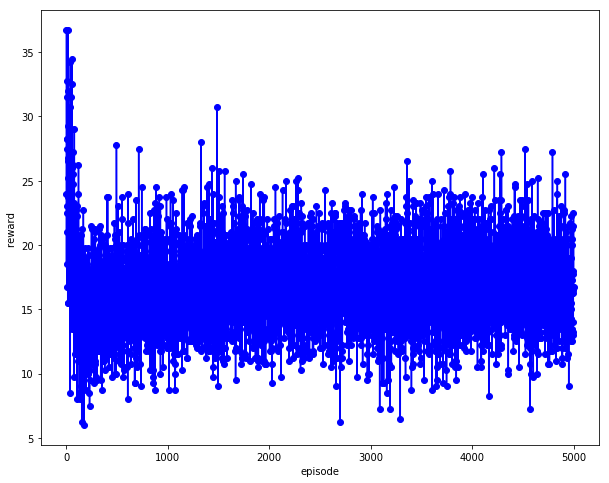

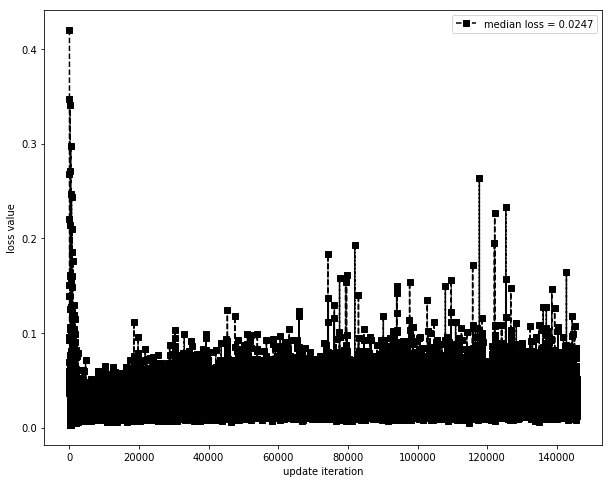

In [168]:
fig = plt.figure()
plt.plot(range(len(rew_hist)), rew_hist, 'b-o')
plt.xlabel('episode')
plt.ylabel('reward ')

fig = plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, 'k--s', label="median loss = %0.4f" %(np.median(loss_hist)))
plt.xlabel('update iteration')
plt.ylabel('loss value')
plt.legend()

In [169]:
Q

array([ 1.72278619,  1.58929694,  1.75338209,  1.71683168,  1.77214742,
        1.63942111,  1.7580688 ,  1.6679678 ,  1.65493655,  1.73851907,
        1.74117911,  1.75691319,  1.86074793,  1.78703821,  1.69148839,
        1.66234124,  1.7048645 ,  1.49031329,  1.80055249,  1.77439725,
        1.8065182 ,  1.77130663,  1.67239594,  1.65228748,  1.73572659,
        1.7192229 ,  1.61786044,  1.71827638,  1.78117716,  1.91307712,
        1.71198976,  1.69486332,  1.70153868,  1.70853949,  1.72142208,
        1.72740805,  1.75829482,  1.69744015,  1.8558687 ,  1.83762252,
        1.70916164,  1.69649863,  1.66888511,  1.77178776,  1.75563192,
        1.75147879,  1.66650081,  1.77007186,  1.77460766,  1.72046626,
        1.72026348,  1.69860029,  1.69637227,  1.73372722,  1.78863645,
        1.74815512,  1.69214773,  1.6872623 ,  1.71736467,  1.85256946,
        1.73909771,  1.85757244,  1.63637102,  1.53013718,  1.66791558,
        1.67182231,  1.7406224 ,  1.65268934,  1.84114242,  1.72

## Test network in simulation

In [170]:
seed = 1

0.76s = 0.01m elapsed


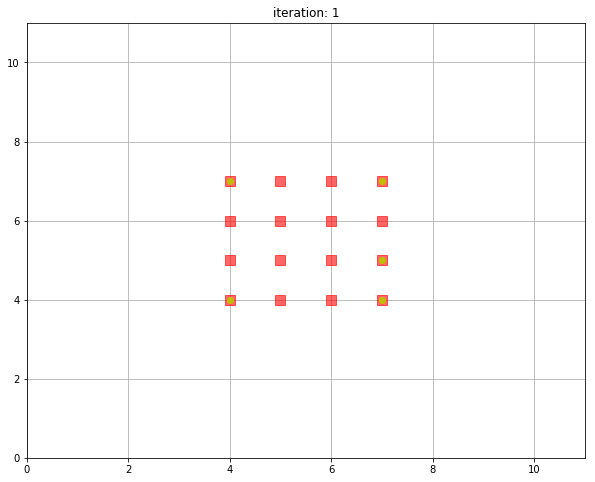

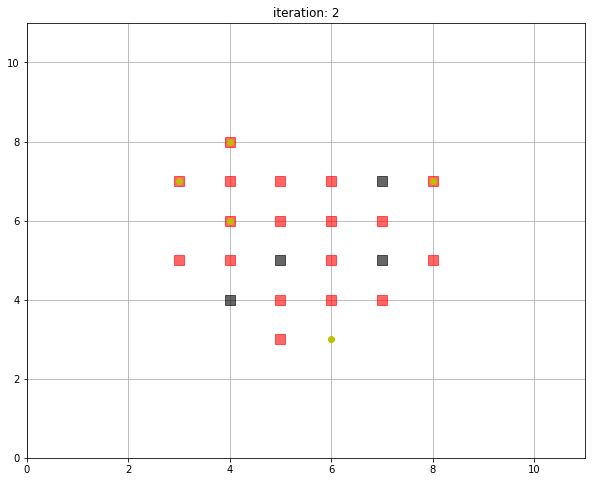

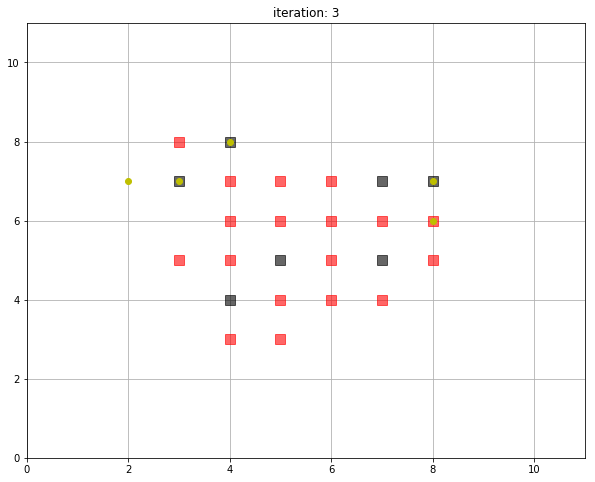

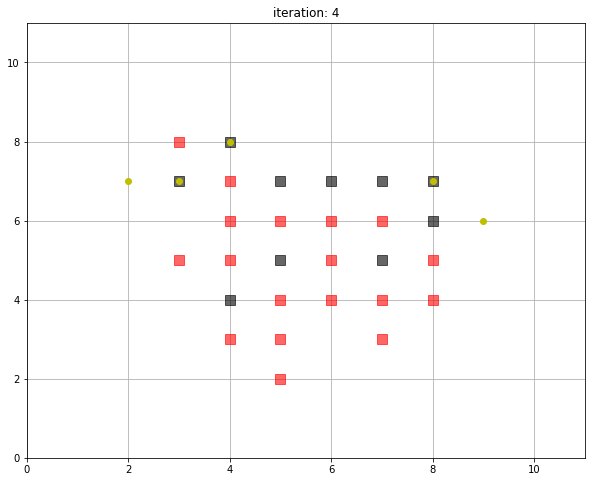

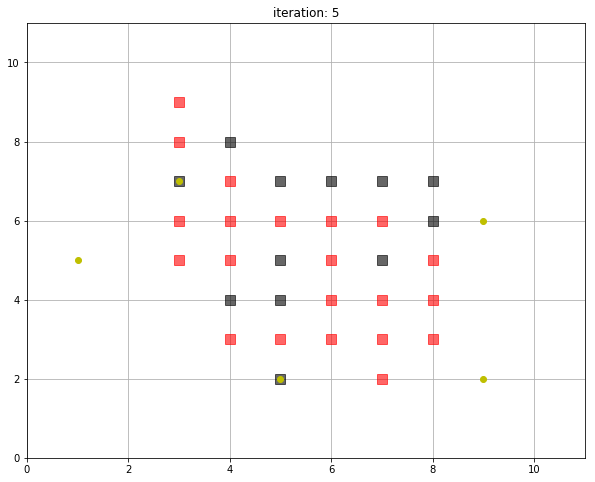

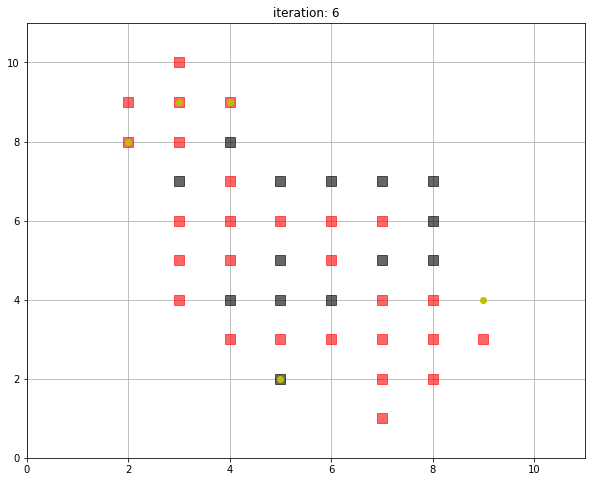

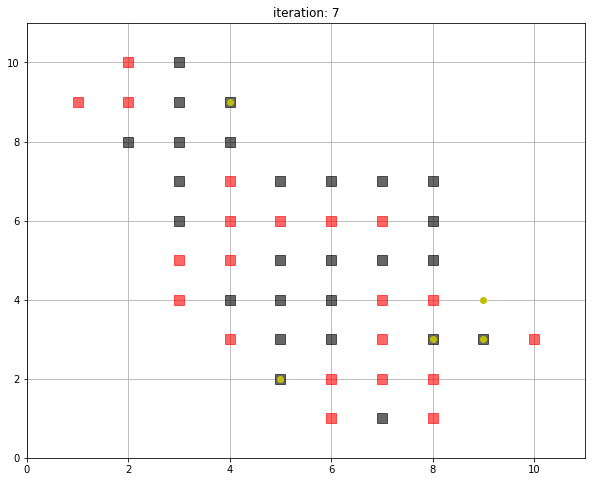

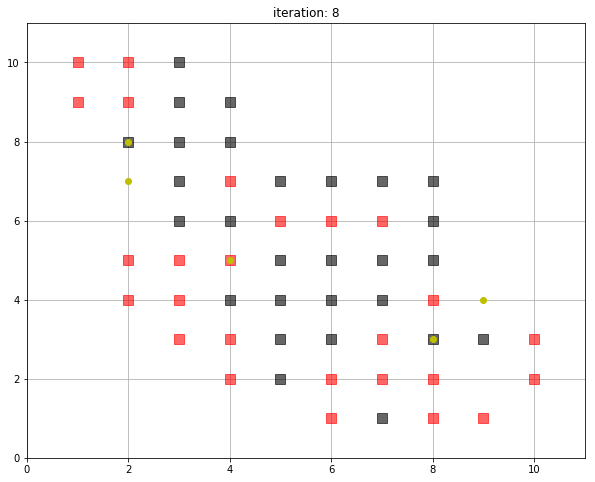

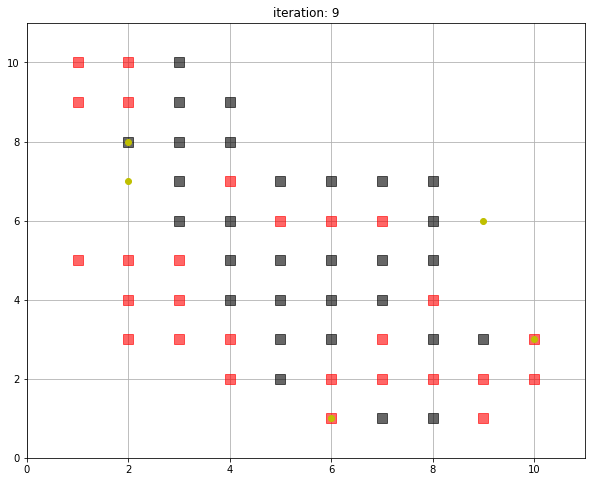

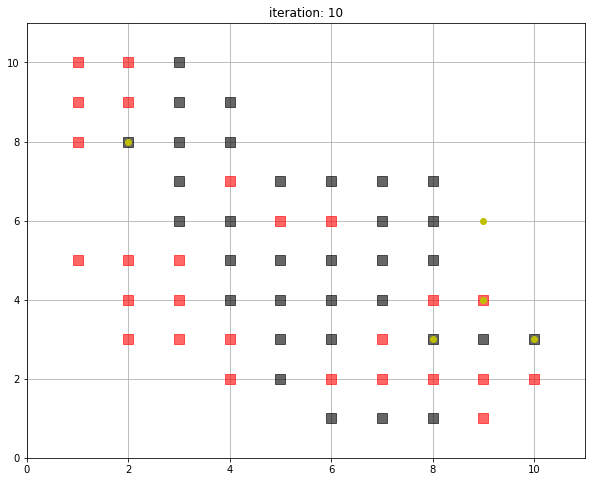

In [171]:
plotting = True
plt.close('all')

tic = time.clock()
# run simulator many times
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

seed_rew = 0
control = []

for _ in range(10):
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d' % (sim.iter))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6,markersize=10)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6,markersize=10)
                    
    # generate state
    state = sim.state.reshape((grid_size**2, ))

    # get action and reward
    state_var = Variable(torch.from_numpy(state)).type(dtype)
    Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
    action = np.argpartition(Q, -num_control)[-num_control:]

    reward, control = eelfff_reward(sim.state, action, num_control)
    
    if plotting:
        for (x,y) in control:
            plt.plot(x,y,"yo")
        
    # apply action and update simulator
    sim.step(control, dbeta=dp)

    seed_rew += np.sum(reward)

toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

In [151]:
Q

array([ 7.91356659,  8.06405163,  7.85622072,  7.91574669,  7.8308959 ,
        8.35964775,  7.93334007,  7.90518332,  7.91077232,  7.93331575,
        8.09004688,  7.82141781,  7.89267159,  7.97836113,  8.37232304,
        7.96637917,  8.15408802,  7.87867403,  8.08434963,  8.14014053,
        7.96312857,  7.94159937,  8.44651985,  7.84772444,  8.0279541 ,
        7.77498674,  7.97852373,  8.24893665,  8.06517696,  7.6209507 ,
        8.25268555,  8.05573082,  8.29231262,  7.61034966,  8.01466942,
        7.96272945,  7.91067505,  7.85376978,  7.85996389,  7.96371698,
        7.96246147,  8.05313778,  8.0551157 ,  8.03103924,  7.88595581,
        8.11636639,  8.01600838,  7.93584013,  8.03327084,  8.24062634,
        7.86305714,  8.16877747,  7.80607891,  8.14535427,  7.6728816 ,
        7.86153364,  8.0408268 ,  8.11855602,  8.14416695,  8.15980625,
        8.0812273 ,  8.11000538,  8.00981045,  7.80841017,  7.82329226,
        7.96791553,  7.87593222,  7.8615346 ,  8.01046658,  7.94

## Benchmark network solution

In [172]:
results = []

In [173]:
seeds = range(1000)

In [174]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    seed_rew = 0
    control = []
    
    while not sim.end:
        # generate state
        state = sim.state.reshape((grid_size**2, ))
        
        # get action and reward
        state_var = Variable(torch.from_numpy(state)).type(dtype)
        Q = model(state_var.unsqueeze(0))[0].data.cpu().numpy()
        action = np.argpartition(Q, -num_control)[-num_control:]

        reward, control = eelfff_reward(sim.state, action, num_control)
        
        # apply action and update simulator
        sim.step(control, dbeta=dp)
        control = []
        
        if sim.end:
            continue
                           
    if (i+1) % 100 == 0:
        print("finished %d simulations" % (i+1))
    
    # store simulation result
    results.append(sim.stats[2]/np.sum(sim.stats)) # fraction of burned trees
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

finished 100 simulations
finished 200 simulations
finished 300 simulations
finished 400 simulations
finished 500 simulations
finished 600 simulations
finished 700 simulations
finished 800 simulations
finished 900 simulations
finished 1000 simulations
38.49s = 0.64m elapsed


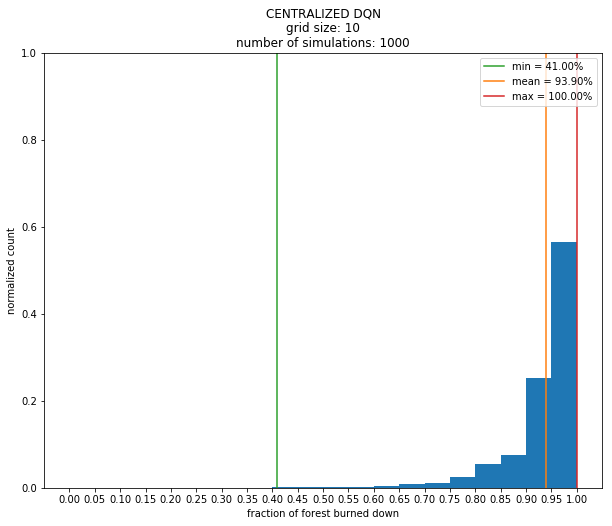

In [175]:
plt.figure()
weights = np.ones_like(results)/float(len(results))
splits, _, _ = plt.hist(results, bins=np.arange(0,1+0.05,0.05), normed=False, weights=weights)
plt.axvline(np.amin(results),color="C2",label="min = %0.2f%%" % (np.amin(results)*100))
plt.axvline(np.mean(results),color="C1",label="mean = %0.2f%%" %(np.mean(results)*100))
plt.axvline(np.amax(results),color="C3",label="max = %0.2f%%" %(np.amax(results)*100))

plt.ylim([0,1])
plt.xticks(np.arange(0,1+0.05,0.05))
plt.xlabel('fraction of forest burned down')
plt.ylabel('normalized count')
plt.title('CENTRALIZED DQN\ngrid size: %d\nnumber of simulations: %d' %(grid_size,len(results)))
plt.legend(loc=1)

# plt.savefig('central.png', bbox_inches='tight')